<a href="https://colab.research.google.com/github/Sarayut-Aree/ML/blob/main/K_NN%2C_RFR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

Data preparation

In [2]:
df = pd.read_csv("/content/healthcare-dataset-stroke-data.csv")
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
df.isna().sum() #missing values

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [4]:
df["bmi"].fillna(df['bmi'].mean(), inplace=True)
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [5]:
print(df['gender'].value_counts())

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64


In [6]:
df = df[df['gender'] != "Other"] #remove row "Other" from gender
print(df['gender'].value_counts())

Female    2994
Male      2115
Name: gender, dtype: int64


In [7]:
df.isna().sum() #missing values

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [8]:
Y = df.iloc[:,[11]]
Y

,stroke
0,1
1,1
2,1
3,1
4,1
...,...
5105,0
5106,0
5107,0
5108,0


In [9]:
count =  Y['stroke'].value_counts()
count

0    4860
1     249
Name: stroke, dtype: int64

In [10]:
fig = px.bar(count)
fig.show()

In [11]:
X = df.iloc[:,1:11]
X

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked
...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.893237,never smoked
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked


In [12]:
df_copy = df

df_result = pd.get_dummies(df_copy, columns=['hypertension', 'heart_disease', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], prefix=['hypertension', 'heart_disease', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'] )
df_result.rename(columns={"hypertension_0": "no_hypertension", "hypertension_1": "yes_hypertension", "heart_disease_0": "no_heart_disease", "heart_disease_1": "yes_heart_disease"}, inplace=True)

print(df_result.columns.tolist())
df_result

['id', 'age', 'avg_glucose_level', 'bmi', 'stroke', 'no_hypertension', 'yes_hypertension', 'no_heart_disease', 'yes_heart_disease', 'gender_Female', 'gender_Male', 'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural', 'Residence_type_Urban', 'smoking_status_Unknown', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']


,id,age,avg_glucose_level,bmi,stroke,no_hypertension,yes_hypertension,no_heart_disease,yes_heart_disease,gender_Female,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,228.69,36.600000,1,1,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0
1,51676,61.0,202.21,28.893237,1,1,0,1,0,1,...,0,0,1,0,1,0,0,0,1,0
2,31112,80.0,105.92,32.500000,1,1,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
3,60182,49.0,171.23,34.400000,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,0,1
4,1665,79.0,174.12,24.000000,1,0,1,1,0,1,...,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,80.0,83.75,28.893237,0,0,1,1,0,1,...,0,1,0,0,0,1,0,0,1,0
5106,44873,81.0,125.20,40.000000,0,1,0,1,0,1,...,0,0,1,0,0,1,0,0,1,0
5107,19723,35.0,82.99,30.600000,0,1,0,1,0,1,...,0,0,1,0,1,0,0,0,1,0
5108,37544,51.0,166.29,25.600000,0,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0


In [13]:
df_result.corr()

,id,age,avg_glucose_level,bmi,stroke,no_hypertension,yes_hypertension,no_heart_disease,yes_heart_disease,gender_Female,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
id,1.000000,0.003677,0.000943,0.003153,0.006430,-0.003610,0.003610,0.001253,-0.001253,-0.001929,...,0.005471,0.023545,-0.019879,-0.013869,0.001219,-0.001219,-0.019126,0.007419,0.011567,0.001081
age,0.003677,1.000000,0.238323,0.325858,0.245239,-0.276367,0.276367,-0.263777,0.263777,0.027752,...,-0.078667,0.116678,0.327949,-0.634320,-0.014031,0.014031,-0.378366,0.237347,0.119207,0.073075
avg_glucose_level,0.000943,0.238323,1.000000,0.168910,0.131991,-0.174540,0.174540,-0.161907,0.161907,-0.054722,...,-0.014665,0.016451,0.062770,-0.102195,0.004783,-0.004783,-0.095035,0.067796,0.024011,0.017716
bmi,0.003153,0.325858,0.168910,1.000000,0.038912,-0.160147,0.160147,-0.038862,0.038862,0.025606,...,-0.028612,0.204055,0.070756,-0.442945,0.000288,-0.000288,-0.265094,0.104674,0.106107,0.085516
stroke,0.006430,0.245239,0.131991,0.038912,1.000000,-0.127891,0.127891,-0.134905,0.134905,-0.009081,...,-0.014885,0.011927,0.062150,-0.083888,-0.015415,0.015415,-0.055924,0.064683,-0.004163,0.008920
no_hypertension,-0.003610,-0.276367,-0.174540,-0.160147,-0.127891,1.000000,-1.000000,0.108292,-0.108292,0.021223,...,0.021612,0.005358,-0.115417,0.129535,-0.007980,0.007980,0.141551,-0.059022,-0.065018,-0.031213
yes_hypertension,0.003610,0.276367,0.174540,0.160147,0.127891,-1.000000,1.000000,-0.108292,0.108292,-0.021223,...,-0.021612,-0.005358,0.115417,-0.129535,0.007980,-0.007980,-0.141551,0.059022,0.065018,0.031213
no_heart_disease,0.001253,-0.263777,-0.161907,-0.038862,-0.134905,0.108292,-0.108292,1.000000,-1.000000,0.085685,...,0.015715,-0.000068,-0.086742,0.091654,0.003045,-0.003045,0.066765,-0.066938,0.021893,-0.044030
yes_heart_disease,-0.001253,0.263777,0.161907,0.038862,0.134905,-0.108292,0.108292,-1.000000,1.000000,-0.085685,...,-0.015715,0.000068,0.086742,-0.091654,-0.003045,0.003045,-0.066765,0.066938,-0.021893,0.044030
gender_Female,-0.001929,0.027752,-0.054722,0.025606,-0.009081,0.021223,-0.021223,0.085685,-0.085685,1.000000,...,-0.011486,0.032502,0.026045,-0.089226,-0.006105,0.006105,-0.059557,-0.043121,0.098952,-0.011408


In [14]:
corr_matrix = df_result.corr()
corr_matrix["stroke"].sort_values(ascending = False)

stroke                            1.000000
age                               0.245239
yes_heart_disease                 0.134905
avg_glucose_level                 0.131991
yes_hypertension                  0.127891
ever_married_Yes                  0.108299
smoking_status_formerly smoked    0.064683
work_type_Self-employed           0.062150
bmi                               0.038912
Residence_type_Urban              0.015415
work_type_Private                 0.011927
gender_Male                       0.009081
smoking_status_smokes             0.008920
id                                0.006430
work_type_Govt_job                0.002660
smoking_status_never smoked      -0.004163
gender_Female                    -0.009081
work_type_Never_worked           -0.014885
Residence_type_Rural             -0.015415
smoking_status_Unknown           -0.055924
work_type_children               -0.083888
ever_married_No                  -0.108299
no_hypertension                  -0.127891
no_heart_di

attributes which have main correlations with stroke (>0.10):

-age 

-avg glucose level 

-hypertension

-heart disease background

-ever married

In [15]:
X = df_result.drop(columns=['stroke', 'id'])
X

,age,avg_glucose_level,bmi,no_hypertension,yes_hypertension,no_heart_disease,yes_heart_disease,gender_Female,gender_Male,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,228.69,36.600000,1,0,0,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0
1,61.0,202.21,28.893237,1,0,1,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
2,80.0,105.92,32.500000,1,0,0,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0
3,49.0,171.23,34.400000,1,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
4,79.0,174.12,24.000000,0,1,1,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,83.75,28.893237,0,1,1,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
5106,81.0,125.20,40.000000,1,0,1,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
5107,35.0,82.99,30.600000,1,0,1,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
5108,51.0,166.29,25.600000,1,0,1,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0


In [16]:
Y = df.iloc[:,[11]]
Y

,stroke
0,1
1,1
2,1
3,1
4,1
...,...
5105,0
5106,0
5107,0
5108,0


In [17]:
split = StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2)
for train_index, test_index in split.split(X, Y):
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
x = {'train': x_train, 'test': x_test}
y = {'train': y_train, 'test': y_test}

In [18]:
scaler = StandardScaler()
x_train_scaled = x_train.copy()
x_test_scaled = x_test.copy()

scaling the numerical features of X_train

In [19]:
scaler.fit(x_train[['age', 'avg_glucose_level', 'bmi']])
x_train_scaled[['age', 'avg_glucose_level', 'bmi']] = scaler.transform(x_train_scaled[['age', 'avg_glucose_level', 'bmi']])

x_train_scaled.describe()

,age,avg_glucose_level,bmi,no_hypertension,yes_hypertension,no_heart_disease,yes_heart_disease,gender_Female,gender_Male,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
count,4.087000e+03,4.087000e+03,4.087000e+03,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,...,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000
mean,-2.022958e-16,2.486661e-16,-2.352127e-16,0.905310,0.094690,0.943235,0.056765,0.586494,0.413506,0.340103,...,0.003915,0.568632,0.162466,0.135796,0.497431,0.502569,0.302422,0.174945,0.371911,0.150722
std,1.000122e+00,1.000122e+00,1.000122e+00,0.292823,0.292823,0.231422,0.231422,0.492522,0.492522,0.473801,...,0.062454,0.495328,0.368923,0.342614,0.500055,0.500055,0.459363,0.379966,0.483374,0.357821
min,-1.907260e+00,-1.134397e+00,-2.402337e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.065280e-01,-6.366512e-01,-6.635186e-01,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.688480e-02,-3.135136e-01,-6.236568e-02,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,7.836150e-01,1.822176e-01,5.064672e-01,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,1.711198e+00,3.712554e+00,8.883825e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


scaling the numerical features of X_train

In [20]:
x_test_scaled[['age', 'avg_glucose_level', 'bmi']] = scaler.transform(x_test_scaled[['age', 'avg_glucose_level', 'bmi']])

In [21]:
k_range = list(range(1, 131, 15))
k_mean_scores = []
k_std_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train_scaled, y_train, cv=10, scoring='accuracy')
    k_mean_scores.append(scores.mean())
    k_std_scores.append(scores.std())

d = {'k_mean': k_mean_scores, 'k_std': k_std_scores}
Ks = pd.DataFrame(data = d, index=k_range)

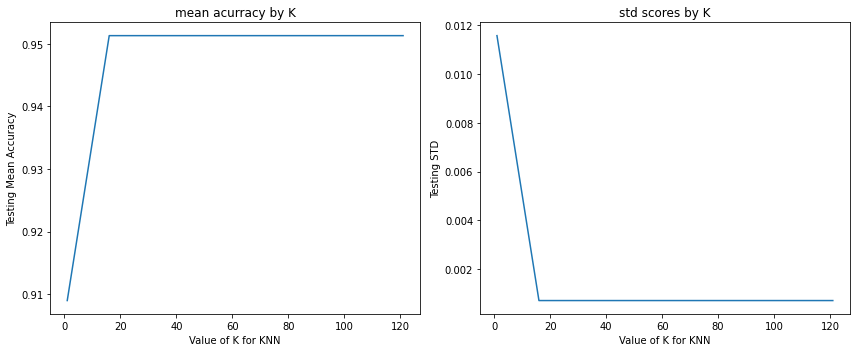

best mean acuarracy is: 0.9513093868354188
the best K's are:
       k_mean     k_std
16   0.951309  0.000709
31   0.951309  0.000709
46   0.951309  0.000709
61   0.951309  0.000709
76   0.951309  0.000709
91   0.951309  0.000709
106  0.951309  0.000709
121  0.951309  0.000709
in this case I will choose the smallest k between those K's for the model, to make it the as simple as we can.


In [22]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
((ax1, ax2)) = ax

ax1.plot(k_range, k_mean_scores)
ax1.set_title('mean acurracy by K')
ax1.set_xlabel('Value of K for KNN')
ax1.set_ylabel('Testing Mean Accuracy')

ax2.plot(k_range, k_std_scores)
ax2.set_title('std scores by K')
ax2.set_xlabel('Value of K for KNN')
ax2.set_ylabel('Testing STD')

plt.tight_layout()
plt.show()

max_score = max(k_mean_scores)
min_std = min(k_std_scores)
best_Ks = Ks[(Ks['k_mean']==max_score) & (Ks['k_std']==min_std)]
print("best mean acuarracy is: " +str(max_score))
print("the best K's are:")
print(best_Ks)
print("in this case I will choose the smallest k between those K's for the model, to make it the as simple as we can.")

In [23]:
min(best_Ks['k_mean'].index)

16

In [24]:
def cf_matrix_show(cf_matrix, beta = 4):

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
    precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
    recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
    f1_score  = 2*precision*recall / (precision + recall)
    fb_score  = (1+beta**2)*precision*recall / ((beta**2)*precision + recall)
    stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}\nFb Score={:0.3f}".format(
                    accuracy,precision,recall,f1_score, fb_score)

    plt.ylabel('True label')
    plt.xlabel('Predicted label' + stats_text)

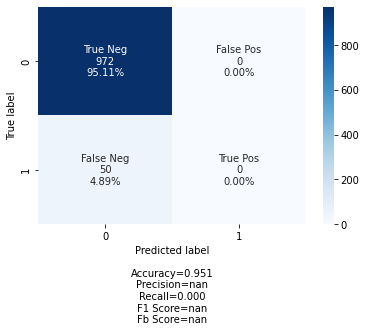

In [25]:
knn = KNeighborsClassifier(n_neighbors=min(best_Ks['k_mean'].index))
knn.fit(x_train_scaled, y_train)
y_predict = knn.predict(x_test_scaled)
cf_matrix_show(confusion_matrix(y_test, y_predict))

In [26]:
print('Confusion Matrix: ')
print(confusion_matrix(y_test, y_predict))
print('Classification Report: ')
print(classification_report(y_test, y_predict))

Confusion Matrix: 
[[972   0]
 [ 50   0]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



Fix over sample 
not balance class

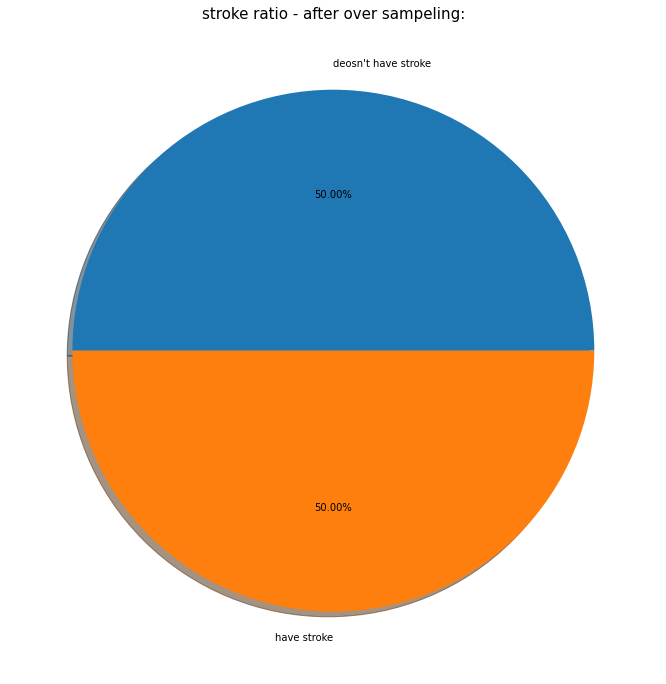

there are now equal number of cases with stroke and without: [3888, 3888]


In [27]:
oversample = SMOTE()
X, y = oversample.fit_resample(x_train_scaled, y_train)
upsampled_df = X.assign(Stroke = y)

fig, ax = plt.subplots(1,1, figsize = (12,12))
labels = ["deosn't have stroke", "have stroke"]
values = upsampled_df['Stroke'].value_counts().tolist()

ax.pie(x=values, labels=labels, autopct="%1.2f%%", shadow=True)
ax.set_title("stroke ratio - after over sampeling:", fontdict={'fontsize': 15})
plt.show()
print("there are now equal number of cases with stroke and without: " +str(values))

In [28]:
x_train_scaled_upsample = upsampled_df.drop(columns='Stroke')
y_train_upsamle = upsampled_df['Stroke']

In [29]:
x_train_scaled_upsample

,age,avg_glucose_level,bmi,no_hypertension,yes_hypertension,no_heart_disease,yes_heart_disease,gender_Female,gender_Male,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.209397,-0.821221,0.545251,1,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
1,-0.629845,-0.485884,-0.993183,1,0,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0
2,-0.364822,0.302317,-0.773407,1,0,1,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
3,-0.232310,0.062342,0.493539,1,0,1,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
4,-1.292405,-0.527297,0.351331,1,0,1,0,0,1,1,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7771,1.332127,-0.311648,-0.780623,1,0,1,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0
7772,1.141194,-0.587907,-0.111179,1,0,1,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
7773,0.348930,-0.530408,-0.455409,1,0,1,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
7774,0.625024,0.224760,0.781504,1,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1


In [30]:
y_train_upsamle

0       0
1       0
2       0
3       0
4       0
       ..
7771    1
7772    1
7773    1
7774    1
7775    1
Name: Stroke, Length: 7776, dtype: int64

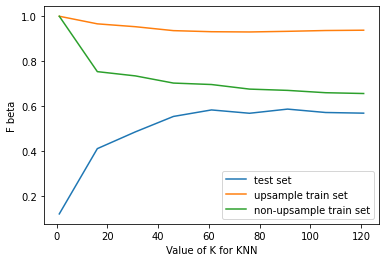

In [31]:
k_range = list(range(1, 131, 15))
beta=4

scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_scaled_upsample, y_train_upsamle)
    y_pred = knn.predict(x_test_scaled)
    scores.append(metrics.fbeta_score(y_test, y_pred, beta=beta))
plt.plot(k_range, scores)

scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_scaled_upsample, y_train_upsamle)
    y_pred = knn.predict(x_train_scaled_upsample)
    scores.append(metrics.fbeta_score(y_train_upsamle, y_pred, beta=beta))
plt.plot(k_range, scores)

scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_scaled_upsample, y_train_upsamle)
    y_pred = knn.predict(x_train_scaled)
    scores.append(metrics.fbeta_score(y_train, y_pred, beta=beta))
    
plt.plot(k_range, scores)

plt.xlabel('Value of K for KNN')
plt.ylabel('F beta')
plt.legend(labels=['test set', 'upsample train set', 'non-upsample train set'])
plt.show()

In [32]:
from imblearn.pipeline import make_pipeline

beta = 4
k_range = range(1,180, 15)
kf = KFold(n_splits=5, random_state=42, shuffle=True)

recall_scores = []
precision_scores = []
Fb_scores = []

for k in k_range:
    imba_pipeline = make_pipeline(SMOTE(random_state=42), 
                              KNeighborsClassifier(n_neighbors= k))

    
    recall = cross_val_score(imba_pipeline, x_train_scaled, y_train, scoring='recall', cv=kf).mean()
    recall_scores.append(recall)
    precision = cross_val_score(imba_pipeline, x_train_scaled, y_train, scoring='precision', cv=kf).mean()
    precision_scores.append(precision)
    fb_score = (1+beta**2)*precision*recall / ((beta**2)*precision + recall)
    Fb_scores.append(fb_score)

pd.set_option('display.max_rows', df.shape[0]+1)    
d = {'Fb': Fb_scores, 'recall': recall_scores, 'precision': precision_scores}
Ks = pd.DataFrame(data = d, index=k_range)
Ks

,Fb,recall,precision
1,0.130325,0.134202,0.089124
16,0.375635,0.435092,0.117884
31,0.471606,0.580969,0.117553
46,0.518620,0.658862,0.117717
61,0.550914,0.728626,0.112376
76,0.542082,0.725458,0.107463
91,0.551611,0.744578,0.107179
106,0.570607,0.769833,0.110999
121,0.577077,0.784509,0.110328
136,0.587326,0.797413,0.112614


remove features using linear correlation.

In [33]:
beta = 4
kf = KFold(n_splits=5, random_state=42, shuffle=True)
k_range = range(1 ,161, 10)
corr_limits = [0, 0.01, 0.02, 0.04, 0.05, 0.06, 0.08, 0.1]

Fb_mean = []
Fb = []

for limit in corr_limits:
    X_tr_copy = x_train_scaled.copy()
    corr_matrix = df_result.corr()
    stroke_corr = corr_matrix["stroke"].sort_values(ascending = False)
    s = (stroke_corr < limit)&(stroke_corr>-limit)
    s.drop(labels=['id', 'stroke'], inplace=True)
    X_tr_copy = X_tr_copy[X_tr_copy.columns[~s]]

    Fb_scores = []
    
    for k in k_range:
        imba_pipeline = make_pipeline(SMOTE(random_state=42), 
                                  KNeighborsClassifier(n_neighbors= k))

        recall = cross_val_score(imba_pipeline, X_tr_copy, y_train, scoring='recall', cv=kf).mean()
        precision = cross_val_score(imba_pipeline, X_tr_copy, y_train, scoring='precision', cv=kf).mean()
        fb_score = (1+beta**2)*precision*recall / ((beta**2)*precision + recall)
        Fb_scores.append(fb_score)
    
    Fb_mean.append(sum(Fb_scores)/len(Fb_scores))
    Fb.append(Fb_scores)

In [34]:
d = {'Fb': Fb_mean}
corr_lim_Fb = pd.DataFrame(data = d, index=corr_limits)
best_corr_lim = corr_lim_Fb['Fb'].idxmax()
best_mean_Fb = corr_lim_Fb['Fb'].max()
print("best correlation limit is: " + str(best_corr_lim) + " , with mean F-beta of " + str(best_mean_Fb))
corr_lim_Fb

best correlation limit is: 0.06 , with mean F-beta of 0.5900973594683878


,Fb
0.00,0.509589
0.01,0.560300
0.02,0.574639
0.04,0.573510
0.05,0.573510
0.06,0.590097
0.08,0.588451
0.10,0.589517


In [35]:
recall_scores = []
precision_scores = []
Fb_scores = []

kf = KFold(n_splits=5, random_state=42, shuffle=True)

limit = best_corr_lim
X_tr_copy = x_train_scaled.copy()
corr_matrix = df_result.corr()
stroke_corr = corr_matrix["stroke"].sort_values(ascending = False)
s = (stroke_corr < limit)&(stroke_corr>-limit)
s.drop(labels=['id', 'stroke'], inplace=True)
X_tr_copy = X_tr_copy[X_tr_copy.columns[~s]]

k_range = range(1 ,161)
for k in k_range:
    imba_pipeline = make_pipeline(SMOTE(random_state=42), 
                              KNeighborsClassifier(n_neighbors= k))
    
    recall = cross_val_score(imba_pipeline, X_tr_copy, y_train, scoring='recall', cv=kf).mean()
    recall_scores.append(recall)
    precision = cross_val_score(imba_pipeline, X_tr_copy, y_train, scoring='precision', cv=kf).mean()
    precision_scores.append(precision)
    fb_score = (1+beta**2)*precision*recall / ((beta**2)*precision + recall)
    Fb_scores.append(fb_score)  

pd.set_option('display.max_rows', df.shape[0]+1)    
d = {'Fb': Fb_scores, 'recall': recall_scores, 'precision': precision_scores}
Ks_best_corr_lim = pd.DataFrame(data = d, index=k_range)

re-call VS precision score by k:


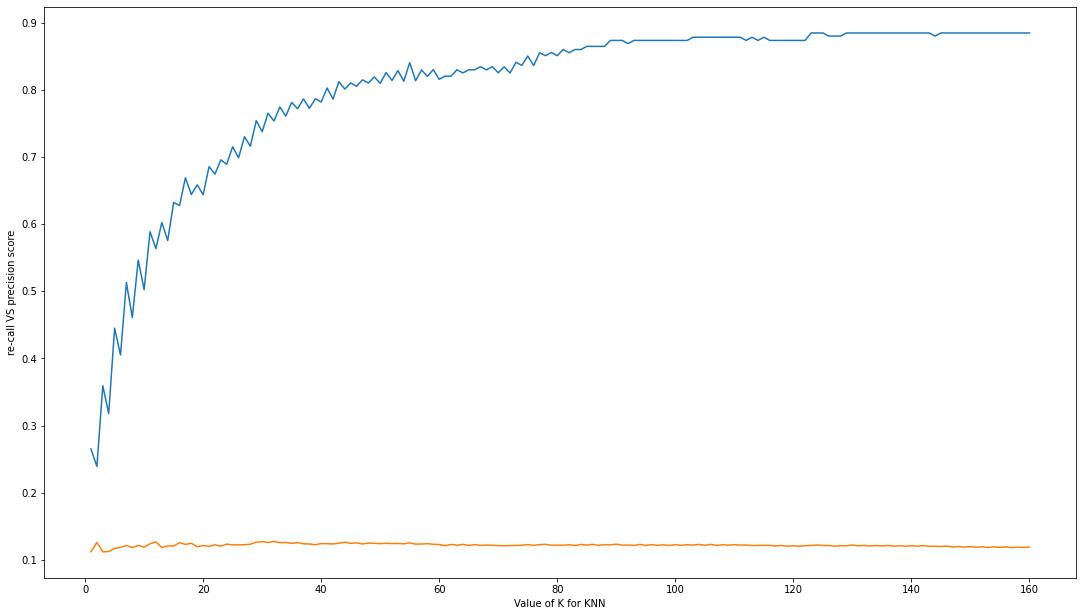

In [36]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(k_range, recall_scores)
plt.plot(k_range, precision_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('re-call VS precision score')

print("re-call VS precision score by k:")

plt.show()

In [37]:
best_Fb = Ks_best_corr_lim['Fb'].max()
best_K = Ks_best_corr_lim['Fb'].idxmax()
print("best K is: " + str(best_K) + " , with Fbeta of " + str(best_Fb))
Ks_best_corr_lim

best K is: 124 , with Fbeta of 0.647072498282199


,Fb,recall,precision
1,0.245466,0.265153,0.112190
2,0.227100,0.239079,0.126048
3,0.317928,0.359242,0.111944
4,0.287059,0.317916,0.112441
5,0.382172,0.445082,0.117177
6,0.354735,0.405098,0.118672
7,0.431270,0.513021,0.121498
8,0.393591,0.460688,0.118185
9,0.453237,0.546389,0.121583
10,0.422253,0.502308,0.118945


In [38]:
print("here it is:")
Ks_best_corr_lim.loc[[best_K]]

here it is:


,Fb,recall,precision
124,0.647072,0.884601,0.122176


 tuning by choosing best treshold

In [39]:
#best_imba_pipeline = make_pipeline(SMOTE(random_state=42), 
#                              KNeighborsClassifier(n_neighbors= best_K))

#limit = best_corr_lim
#X_tr_copy = x_train_scaled.copy()
#corr_matrix = df_result.corr()
#stroke_corr = corr_matrix["stroke"].sort_values(ascending = False)
#s = (stroke_corr < limit)&(stroke_corr>-limit)
#s.drop(labels=['id', 'stroke'], inplace=True )
#X_tr_copy = X_tr_copy[X_tr_copy.columns[~s]]

#predict_probability = cross_val_predict(best_imba_pipeline, X_tr_copy, y_train, cv=kf, method='predict_proba')
#predict_probability

# keep probabilities for the positive outcome only
#stroke_prob = predict_probability[:, 1]
#precision, recall, thresholds = precision_recall_curve(y_train, stroke_prob)
# convert to f-beta score
#fb_score = ((1+beta**2) * precision * recall) / ((beta**2)*precision + recall)
# locate the index of the largest fb score
#np.nan_to_num(fb_score, nan=0, copy=False)
#ix = fb_score.argmax(axis=0)

#print('Best Threshold = %f with Fb-Score of %.3f' % (thresholds[ix], fb_score[ix]))

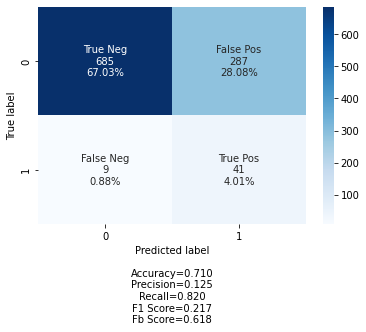

In [40]:
best_imba_pipeline = make_pipeline(SMOTE(random_state=42), 
                              KNeighborsClassifier(n_neighbors= best_K))
limit = best_corr_lim
X_tr_copy = x_train_scaled.copy()
X_test_copy = x_test_scaled.copy()
corr_matrix = df_result.corr()
stroke_corr = corr_matrix["stroke"].sort_values(ascending = False)
s = (stroke_corr < limit)&(stroke_corr>-limit)
s.drop(labels=['id', 'stroke'], inplace=True)
X_tr_copy = X_tr_copy[X_tr_copy.columns[~s]]
X_test_copy = X_test_copy[X_test_copy.columns[~s]]

best_imba_pipeline.fit(X_tr_copy, y_train)
y_prob = best_imba_pipeline.predict_proba(X_test_copy)
# keep probabilities for the positive outcome only
y_prob = y_prob[:, 1]
y_predict = np.where(y_prob < 0.564516, 0, 1)

cf_matrix_show(confusion_matrix(y_test, y_predict), beta=4)

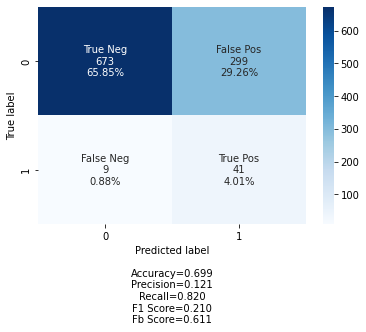

In [41]:
limit = best_corr_lim
X_tr_copy = x_train_scaled_upsample.copy()
X_test_copy = x_test_scaled.copy()
corr_matrix = df_result.corr()
stroke_corr = corr_matrix["stroke"].sort_values(ascending = False)
s = (stroke_corr < limit)&(stroke_corr>-limit)
s.drop(labels=['id', 'stroke'], inplace=True)
X_tr_copy = X_tr_copy[X_tr_copy.columns[~s]]
X_test_copy = X_test_copy[X_test_copy.columns[~s]]

knn = KNeighborsClassifier(n_neighbors=best_K)
knn.fit(X_tr_copy, y_train_upsamle)
y_predict = knn.predict(X_test_copy)

cf_matrix_show(confusion_matrix(y_test, y_predict), beta=4)

In [135]:
limit = best_corr_lim
X_tr_copy = x_train_scaled.copy()
X_test_copy = x_test_scaled.copy()
corr_matrix = df_result.corr()
stroke_corr = corr_matrix["stroke"].sort_values(ascending = False)
s = (stroke_corr < limit)&(stroke_corr>-limit)
s.drop(labels=['id', 'stroke'], inplace=True)
X_tr_copy = X_tr_copy[X_tr_copy.columns[~s]]
X_test_copy = X_test_copy[X_test_copy.columns[~s]]

In [136]:
from imblearn.pipeline import Pipeline

imba_pipeline = Pipeline([
    ('sampling', SMOTE(random_state=42)), 
    ('classification', KNeighborsClassifier())])

In [137]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
f_4_scorer = make_scorer(fbeta_score, beta=4)

knn_param_grid = [
    
    {
     'classification__n_neighbors': list(range(20,50)),
     'classification__weights':['uniform','distance'],
     'classification__metric': ['euclidean','manhattan','minkowski'],
    }
    
]

grid_search_knn = GridSearchCV(
    imba_pipeline,
    param_grid=knn_param_grid,
    cv=kf,
    scoring=f_4_scorer,
    return_train_score=True,
)
grid_search_knn.fit(X=X_tr_copy,y=y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('classification',
                                        KNeighborsClassifier())]),
             param_grid=[{'classification__metric': ['euclidean', 'manhattan',
                                                     'minkowski'],
                          'classification__n_neighbors': [20, 21, 22, 23, 24,
                                                          25, 26, 27, 28, 29,
                                                          30, 31, 32, 33, 34,
                                                          35, 36, 37, 38, 39,
                                                          40, 41, 42, 43, 44,
                                                          45, 46, 47, 48, 49],
                          'classification__weights': ['uniform', 'distance']}],
             return_train_score=True,

In [138]:
grid_search_knn.best_score_

0.614634880369147

In [139]:
best = grid_search_knn.best_estimator_
best

Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('classification',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=49))])

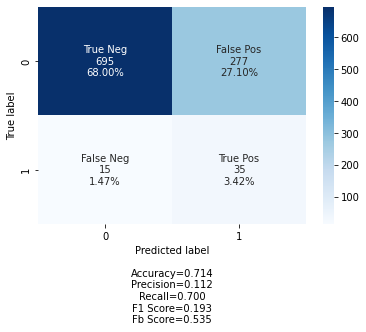

In [140]:
best_knn_pipeline = make_pipeline(SMOTE(random_state=42), 
                              best)

limit = best_corr_lim
X_tr_copy = x_train_scaled.copy()
X_test_copy = x_test_scaled.copy()
corr_matrix = df_result.corr()
stroke_corr = corr_matrix["stroke"].sort_values(ascending = False)
s = (stroke_corr < limit)&(stroke_corr>-limit)
s.drop(labels=['id', 'stroke'], inplace=True)
X_tr_copy = X_tr_copy[X_tr_copy.columns[~s]]
X_test_copy = X_test_copy[X_test_copy.columns[~s]]

best_knn_pipeline.fit(X_tr_copy, y_train)
y_predict = best.predict(X_test_copy)

cf_matrix_show(confusion_matrix(y_test, y_predict), beta=4)

In [141]:
list(best_imba_pipeline)[1].get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 124,
 'p': 2,
 'weights': 'uniform'}

# RFR

In [46]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200) # randomly choose
clf.fit(x_train_scaled_upsample, y_train_upsamle)
 
# Predict on training set
pred_y = clf.predict(x_train_scaled) 

# How's our Fbeta?
print('on train-set scores (over-fitting):')
print('test-set')
print('Fb: '+ str(metrics.fbeta_score(y_train, pred_y, beta=4)) )
print('recall:' + str(metrics.recall_score(y_train, pred_y)) )
print('precision:' + str(metrics.precision_score(y_train, pred_y)) )
print()

# Predict on training set
pred_y = clf.predict(x_test_scaled)

# How's our Fbeta?
print('on test-set scores (very low):')
print('Fb: '+ str(metrics.fbeta_score(y_test, pred_y, beta=4)) )
print('recall:' + str(metrics.recall_score(y_test, pred_y)) )
print('precision:' + str(metrics.precision_score(y_test, pred_y)) )
print()

on train-set scores (over-fitting):
test-set
Fb: 1.0
recall:1.0
precision:1.0

on test-set scores (very low):
Fb: 0.20094562647754138
recall:0.2
precision:0.21739130434782608



In [48]:
feature_imp = pd.Series(clf.feature_importances_,index=x_train_scaled_upsample.columns).sort_values(ascending=False)
feature_imp

age                               0.343879
avg_glucose_level                 0.135092
bmi                               0.132000
ever_married_No                   0.047993
no_hypertension                   0.038286
smoking_status_never smoked       0.026940
ever_married_Yes                  0.023047
work_type_Private                 0.022451
work_type_Self-employed           0.021619
gender_Male                       0.021338
smoking_status_Unknown            0.020611
Residence_type_Rural              0.019675
Residence_type_Urban              0.019150
gender_Female                     0.018667
smoking_status_smokes             0.018218
smoking_status_formerly smoked    0.017901
work_type_Govt_job                0.017159
no_heart_disease                  0.015547
yes_hypertension                  0.015527
work_type_children                0.015153
yes_heart_disease                 0.009664
work_type_Never_worked            0.000084
dtype: float64

In [49]:
# copy X with columns wich grater than limit:
def copy_by_imp_limit(X, lim, limits):
    X_copy = X.copy()
    s = (feature_imp < lim)
    X_copy = X_copy[X_copy.columns[~s]]
    return X_copy

In [56]:
def Fb_recall_precision(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred_y = clf.predict(X_test)
    fb_score = metrics.fbeta_score(y_test, pred_y, beta=4) 
    recall = metrics.recall_score(y_test, pred_y) 
    precision = metrics.precision_score(y_test, pred_y)
    return fb_score, recall, precision

beta = 4
kf = KFold(n_splits=5, random_state=42, shuffle=True)
def Fb_recall_precision_CV(model, X_train, y_train):
    recall = cross_val_score(model, X_train, y_train, scoring='recall', cv=kf).mean()
    precision = cross_val_score(model, X_train, y_train, scoring='precision', cv=kf).mean()
    fb_score = (1+beta**2)*precision*recall / ((beta**2)*precision + recall)
    return fb_score, recall, precision

In [57]:
def df_Fb_recall_precision(Fb_list, recall_list, precision_list):
    d = {'Fb': Fb_list, 'recall': recall_list, 'precision': precision_list}
    return pd.DataFrame(data = d, index=importance_limit)

In [58]:
importance_limit = [0, 0.01, 0.02, 0.04, 0.13, 0.132, 0.14]
    
Fb_list = []
recall_list = []
precision_list = []

for limit in importance_limit:
    X_tr_copy = copy_by_imp_limit(x_train_scaled_upsample, limit, feature_imp)
    X_test_copy = copy_by_imp_limit(x_test_scaled, limit, feature_imp)
    
    fb_score, recall, precision = Fb_recall_precision(clf, X_tr_copy, y_train_upsamle, X_test_copy, y_test)

    Fb_list.append(fb_score)
    recall_list.append(recall)
    precision_list.append(precision)

In [59]:
df_scores_limits = df_Fb_recall_precision(Fb_list, recall_list, precision_list)
best_imp_lim = df_scores_limits['Fb'].idxmax()
best_imp_Fb = df_scores_limits['Fb'].max()
df_scores_limits

,Fb,recall,precision
0.000,0.201183,0.20,0.222222
0.010,0.177494,0.18,0.145161
0.020,0.264739,0.28,0.141414
0.040,0.341077,0.38,0.129252
0.130,0.366906,0.42,0.121387
0.132,0.340358,0.38,0.127517
0.140,0.000000,0.00,0.000000


In [60]:
print("best importance limit is: " + str(best_imp_lim) + " , with mean F-beta of " + str(best_imp_Fb))

best importance limit is: 0.13 , with mean F-beta of 0.3669064748201439


In [61]:
from imblearn.pipeline import Pipeline

f_4_scorer = make_scorer(fbeta_score, beta=4)
imba_pipeline_RFC = Pipeline([
    ('sampling', SMOTE(random_state=42)), 
    ('classification', RandomForestClassifier())])

In [68]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'classification__n_estimators': n_estimators,
               'classification__max_features': max_features,
               'classification__max_depth': max_depth,
               'classification__min_samples_split': min_samples_split,
               'classification__min_samples_leaf': min_samples_leaf,
               'classification__bootstrap': bootstrap}

In [69]:
#kf = KFold(n_splits=5, random_state=42, shuffle=True)
# search across 100 different combinations, and use all availimba_pipelineores
#rf_random = RandomizedSearchCV(estimator = imba_pipeline_RFC, param_distributions = random_grid, n_iter = 100, cv = kf, verbose=2, random_state=42, n_jobs = 2, scoring=f_4_scorer)

# Fit the random search model

#rf_random.fit(x_train_scaled, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: ignored

## Basic Model RFR

In [79]:
ModelDT = DecisionTreeClassifier(criterion="entropy", splitter='best',max_depth =10 )
ModelDT.fit(x_train_scaled_upsample,y_train_upsamle)

DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [80]:
y_pred= ModelDT.predict(x_test_scaled)
DTScore = accuracy_score(y_test, y_pred)
print(DTScore)

0.7553816046966731


In [81]:
print('Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred))
print('Classification Report: ')
print(classification_report(y_test, y_pred))

Confusion Matrix: 
[[739 233]
 [ 17  33]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       972
           1       0.12      0.66      0.21        50

    accuracy                           0.76      1022
   macro avg       0.55      0.71      0.53      1022
weighted avg       0.94      0.76      0.82      1022



In [130]:
RandomF = RandomForestClassifier(criterion="entropy",n_estimators=108, n_jobs=2, max_depth=6,min_samples_split=5, min_samples_leaf=8,max_features='sqrt', random_state=55, bootstrap=True)
RandomF.fit(x_train_scaled_upsample,y_train_upsamle)

RandomForestClassifier(criterion='entropy', max_depth=6, max_features='sqrt',
                       min_samples_leaf=8, min_samples_split=5,
                       n_estimators=108, n_jobs=2, random_state=55)

In [131]:
y_pred= RandomF.predict(x_test_scaled)
RFScore = accuracy_score(y_test, y_pred)
print(RFScore)

0.7054794520547946


In [132]:
print('Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred))
print('Classification Report: ')
print(classification_report(y_test, y_pred))

Confusion Matrix: 
[[680 292]
 [  9  41]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.70      0.82       972
           1       0.12      0.82      0.21        50

    accuracy                           0.71      1022
   macro avg       0.56      0.76      0.52      1022
weighted avg       0.94      0.71      0.79      1022

